# <center> Bayesian age estimation model </center>



In [2]:
!pip install wget wfdb neurokit2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json'

kaggle.json
/bin/bash: -c: line 0: unexpected EOF while looking for matching `''
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [4]:
!kaggle datasets download -d bjoernjostein/ptbxl-electrocardiography-database

ptbxl-electrocardiography-database.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import os, zipfile

dir_name = "./"
extension = ".zip"
 
os.chdir(dir_name) # change directory from working dir to dir with files

for item in os.listdir(dir_name): # loop through items in dir
    if item.endswith(extension): # check for ".zip" extension
        file_name = os.path.abspath(item) # get full path of files
        zip_ref = zipfile.ZipFile(file_name) # create zipfile object
        zip_ref.extractall(dir_name) # extract file to dir
        zip_ref.close() # close file
        os.remove(file_name) # delete zipped file

KeyboardInterrupt: ignored

In [ ]:
import shutil
import os
os.mkdir("/content/ecg_age/data")
sources = ["WFDB/"]
dest1 = '/content/ecg_age/data/'


for s in sources:
  files = os.listdir(s)
  for f in files:
      shutil.move(s+f, dest1)

In [6]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tqdm
from scipy import signal
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
from scipy.io import loadmat
from scipy import signal
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload
%reload_ext autoreload
sns.set_style("dark")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
def load_challenge_data(filename):
    x = loadmat(filename)
    data = np.asarray(x["val"], dtype=np.float64)
    new_file = filename.replace(".mat", ".hea")
    input_header_file = os.path.join(new_file)
    with open(input_header_file, "r") as f:
        header_data = f.readlines()
    return data, header_data

def downsample_ecg(ecg, samples=1000, leads=12):
  new_ecg = np.zeros((samples,leads))
  for i,j in enumerate(ecg):
    new_ecg[:,i] = signal.resample(j,samples)
  return new_ecg

def import_key_data(path):
    gender = []
    age = []
    labels = []
    ecg = []
    for subdir, dirs, files in sorted(os.walk(path)):
        for filename in tqdm.tqdm(files):
            filepath = subdir + os.sep + filename
            if filepath.endswith(".mat"):
                data, header_data = load_challenge_data(filepath)
                if (
                    int(header_data[0].split(" ")[3])
                    // int(header_data[0].split(" ")[2])
                    == 10
                ):
                    labels.append(header_data[15][5:-1])
                    ecg.append(downsample_ecg(data))
                    gender.append(header_data[14][6:-1])
                    age.append(header_data[13][6:-1])
    return gender, age, labels, ecg




def clean_up_age_data(age):
    age[np.where(age == "60.")] = 60
    age = age.astype(int)
    return age


def clean_up_gender_data(gender):
    gender[np.where(gender == "Male")] = 0
    gender[np.where(gender == "male")] = 0
    gender[np.where(gender == "M")] = 0
    gender[np.where(gender == "Female")] = 1
    gender[np.where(gender == "female")] = 1
    gender[np.where(gender == "F")] = 1
    gender[np.where(gender == "NaN")] = 2
    gender = gender.astype(np.int)
    return gender


In [30]:
import os

In [31]:
######################################################
print("Collecting labels, ECG filenames and metadata...")
gender, age, labels, ecgs = import_key_data("/content/ecg_age/data/")
ecgs = np.asarray(ecgs)
age = np.asarray(age)
gender = np.asarray(gender)
labels = np.asarray(labels)
print(f"Total number of patients found: {len(age)}")

100%|██████████| 43674/43674 [01:10<00:00, 623.77it/s]


Total number of patients found: 21837


In [45]:
ecgs = np.delete(ecgs, np.where(age == "NaN"), axis=0)
gender = np.delete(gender, np.where(age == "NaN"))
labels = np.delete(labels, np.where(age == "NaN"))
age = np.delete(age, np.where(age == "NaN"))

In [46]:
age = clean_up_age_data(age)
gender = clean_up_gender_data(gender)

print(f"Total number of patients left after data cleaning: {len(age)}")

Total number of patients left after data cleaning: 21748


In [47]:
print(f"Total number of patients left after selection and data cleaning: {len(age)}")

Total number of patients left after selection and data cleaning: 21748


In [54]:
!pip install tensorflow-probability==0.9.0 
!pip install tensorflow==2.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 91.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.0/26.0 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 95.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.6/454.6 KB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 KB 21.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      S

In [56]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [59]:
n_batches = (len(ecgs) * 0.8)//16
n_batches

1087.0

In [48]:



def _inception_module(
    input_tensor,
    stride=1,
    activation="linear",
    use_bottleneck=True,
    kernel_size=40,
    bottleneck_size=32,
    nb_filters=32,
):

    if use_bottleneck and int(input_tensor.shape[-1]) > 1:
        input_inception = tf.keras.layers.Conv1D(
            filters=bottleneck_size,
            kernel_size=1,
            padding="same",
            activation=activation,
            use_bias=False,
        )(input_tensor)
    else:
        input_inception = input_tensor

    # kernel_size_s = [3, 5, 8, 11, 17]
    kernel_size_s = [kernel_size // (2**i) for i in range(3)]

    conv_list = []

    for i in range(len(kernel_size_s)):
        conv_list.append(
            tf.keras.layers.Conv1D(
                filters=nb_filters,
                kernel_size=kernel_size_s[i],
                strides=stride,
                padding="same",
                activation=activation,
                use_bias=False,
            )(input_inception)
        )

    max_pool_1 = tf.keras.layers.MaxPool1D(pool_size=3, strides=stride, padding="same")(
        input_tensor
    )

    conv_6 = tf.keras.layers.Conv1D(
        filters=nb_filters,
        kernel_size=1,
        padding="same",
        activation=activation,
        use_bias=False,
    )(max_pool_1)

    conv_list.append(conv_6)

    x = tf.keras.layers.Concatenate(axis=2)(conv_list)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation="relu")(x)
    return x


def _shortcut_layer(input_tensor, out_tensor):
    shortcut_y = tf.keras.layers.Conv1D(
        filters=int(out_tensor.shape[-1]), kernel_size=1, padding="same", use_bias=False
    )(input_tensor)
    shortcut_y = tf.keras.layers.BatchNormalization()(shortcut_y)

    x = tf.keras.layers.Add()([shortcut_y, out_tensor])
    x = tf.keras.layers.Activation("relu")(x)
    return x


def build_model(
    input_shape,
    nb_classes: int,
    depth: int = 6,
    use_residual: bool = True,
)-> tf.keras.models.Model:
    """
    Model proposed by HI Fawas et al 2019 "Finding AlexNet for Time Series Classification - InceptionTime"
    """
    input_layer = tf.keras.layers.Input(input_shape)

    x = input_layer
    input_res = input_layer

    for d in range(depth):

        x = _inception_module(x)

        if use_residual and d % 3 == 2:
            x = _shortcut_layer(input_res, x)
            input_res = x

    gap_layer = tf.keras.layers.GlobalAveragePooling1D()(x)

    output_layer = tf.keras.layers.Dense(units=nb_classes, activation="linear")(
        gap_layer
    )

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        loss=tf.keras.losses.MeanAbsoluteError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=[tf.keras.metrics.MeanSquaredError()],
    )

    return model


Bruker denne URLen (https://keras.io/examples/keras_recipes/bayesian_neural_networks/) som hjelp til å implementere Bayesian layers

In [69]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

In [99]:
# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [106]:


def build_bayesian_model(
    input_shape,
    nb_classes: int,
    depth: int = 6,
    use_residual: bool = True,
)-> tf.keras.models.Model:
    """
    Model proposed by HI Fawas et al 2019 "Finding AlexNet for Time Series Classification - InceptionTime"
    """
    input_layer = tf.keras.layers.Input(input_shape)

    x = input_layer
    input_res = input_layer

    for d in range(depth):

        x = _inception_module(x)

        if use_residual and d % 3 == 2:
            x = _shortcut_layer(input_res, x)
            input_res = x

    gap_layer = tf.keras.layers.GlobalAveragePooling1D()(x)

    features = tfp.layers.DenseVariational(
            units=8,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / 1087, # 1/train_size
            activation="sigmoid",
        )(gap_layer)
    distribution_params = tf.keras.layers.Dense(units=2)(features)

    output_layer = tfp.layers.IndependentNormal(1)(distribution_params)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model


In [146]:
def run_experiment(model, loss, xtrain,ytrain):

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
        loss=loss,
        metrics=[keras.metrics.RootMeanSquaredError()],
    )

    print("Start training the model...")
    model.fit(x=xtrain,y=ytrain, epochs=30)
    print("Model training finished.")
    #_, rmse = model.evaluate(train_dataset, verbose=0)
    #print(f"Train RMSE: {round(rmse, 3)}")

In [147]:
model = build_bayesian_model((samp_freq*time,num_leads), 1)

In [148]:
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 1000, 12)]   0           []                               
                                                                                                  
 conv1d_768 (Conv1D)            (None, 1000, 32)     384         ['input_25[0][0]']               
                                                                                                  
 max_pooling1d_144 (MaxPooling1  (None, 1000, 12)    0           ['input_25[0][0]']               
 D)                                                                                               
                                                                                                  
 conv1d_769 (Conv1D)            (None, 1000, 32)     40960       ['conv1d_768[0][0]']      

In [149]:
age = age.astype(float)

In [150]:
samp_freq = 100
time = 10
num_leads = 12
batchsize = 16
epoch = 30
mae_score_total = []

print("Training model...")



model = build_bayesian_model((samp_freq*time,num_leads), 1)
run_experiment(model, negative_loglikelihood, ecgs, age)
#model.fit(x=ecgs, y=age, validation_split=0.2, epochs=epoch, 
#            steps_per_epoch=(len(ecgs)/batchsize), 
#            verbose = 1)

Training model...
Start training the model...
Epoch 1/30
680/680 [==============================] - 59s 80ms/step - loss: 490.5470 - root_mean_squared_error: 59.3290
Epoch 2/30
680/680 [==============================] - 54s 79ms/step - loss: 35.7689 - root_mean_squared_error: 54.5536
Epoch 3/30
680/680 [==============================] - 54s 79ms/step - loss: 10.5043 - root_mean_squared_error: 50.1487
Epoch 4/30
680/680 [==============================] - 54s 79ms/step - loss: 6.5096 - root_mean_squared_error: 46.8044
Epoch 5/30
680/680 [==============================] - 54s 79ms/step - loss: 5.3936 - root_mean_squared_error: 44.9052
Epoch 6/30
680/680 [==============================] - 54s 79ms/step - loss: 5.0417 - root_mean_squared_error: 43.9379
Epoch 7/30
680/680 [==============================] - 54s 79ms/step - loss: 4.8781 - root_mean_squared_error: 39.7765
Epoch 8/30
680/680 [==============================] - 54s 79ms/step - loss: 4.7141 - root_mean_squared_error: 34.2025
Epoch 

In [187]:
prediction_distribution = model(ecgs[0:100])

In [188]:
prediction_mean = prediction_distribution.mean().numpy().tolist()
prediction_mean

[[64.18186950683594],
 [64.04885864257812],
 [57.45804214477539],
 [56.23747253417969],
 [66.72325897216797],
 [64.93323516845703],
 [49.150447845458984],
 [66.9429931640625],
 [63.16047668457031],
 [63.403953552246094],
 [66.55436706542969],
 [52.46300506591797],
 [63.83372497558594],
 [65.593994140625],
 [57.26483917236328],
 [29.48477554321289],
 [59.45000457763672],
 [48.59263229370117],
 [44.44319534301758],
 [57.77980041503906],
 [48.84201431274414],
 [53.340484619140625],
 [50.043121337890625],
 [47.175392150878906],
 [61.42977523803711],
 [41.021968841552734],
 [56.53047180175781],
 [48.997955322265625],
 [65.06724548339844],
 [43.349735260009766],
 [48.62925720214844],
 [47.34669494628906],
 [67.55040740966797],
 [67.78736877441406],
 [58.096561431884766],
 [67.4615707397461],
 [63.987911224365234],
 [25.929367065429688],
 [64.6092529296875],
 [51.14102554321289],
 [50.847103118896484],
 [24.168235778808594],
 [64.89127349853516],
 [39.15247344970703],
 [47.36112594604492],
 [

In [189]:
prediction_stdv = prediction_distribution.stddev().numpy()
prediction_stdv

array([[11.516092 ],
       [11.462268 ],
       [11.1628065],
       [11.085354 ],
       [11.746468 ],
       [11.553346 ],
       [10.592386 ],
       [11.773462 ],
       [11.411301 ],
       [11.516415 ],
       [11.72466  ],
       [10.86652  ],
       [11.537406 ],
       [11.609503 ],
       [11.22509  ],
       [ 7.9199944],
       [11.282902 ],
       [10.554775 ],
       [10.1872015],
       [11.240019 ],
       [10.552584 ],
       [10.864654 ],
       [10.685028 ],
       [10.397613 ],
       [11.242695 ],
       [ 9.544888 ],
       [11.0378685],
       [10.560037 ],
       [11.622056 ],
       [10.049624 ],
       [10.542755 ],
       [10.463625 ],
       [11.845636 ],
       [11.874585 ],
       [11.320458 ],
       [11.8348465],
       [11.533873 ],
       [ 7.4479933],
       [11.532891 ],
       [10.757145 ],
       [10.688211 ],
       [ 7.2792215],
       [11.550371 ],
       [ 9.471672 ],
       [10.432012 ],
       [11.0426035],
       [11.013068 ],
       [11.85

In [190]:
# The 95% CI is computed as mean ± (1.96 * stdv)
upper = (prediction_mean + (1.96 * prediction_stdv)).tolist()
lower = (prediction_mean - (1.96 * prediction_stdv)).tolist()
prediction_stdv = prediction_stdv.tolist()

In [191]:
for idx in range(len(ecgs[0:100])):
    print(
        f"Prediction mean: {round(prediction_mean[idx][0], 2)}, "
        f"stddev: {round(prediction_stdv[idx][0], 2)}, "
        f"95% CI: [{round(upper[idx][0], 2)} - {round(lower[idx][0], 2)}]"
        f" - Actual: {age[idx]}"
    )

Prediction mean: 64.18, stddev: 11.52, 95% CI: [86.75 - 41.61] - Actual: 77.0
Prediction mean: 64.05, stddev: 11.46, 95% CI: [86.51 - 41.58] - Actual: 58.0
Prediction mean: 57.46, stddev: 11.16, 95% CI: [79.34 - 35.58] - Actual: 69.0
Prediction mean: 56.24, stddev: 11.09, 95% CI: [77.96 - 34.51] - Actual: 83.0
Prediction mean: 66.72, stddev: 11.75, 95% CI: [89.75 - 43.7] - Actual: 72.0
Prediction mean: 64.93, stddev: 11.55, 95% CI: [87.58 - 42.29] - Actual: 79.0
Prediction mean: 49.15, stddev: 10.59, 95% CI: [69.91 - 28.39] - Actual: 72.0
Prediction mean: 66.94, stddev: 11.77, 95% CI: [90.02 - 43.87] - Actual: 86.0
Prediction mean: 63.16, stddev: 11.41, 95% CI: [85.53 - 40.79] - Actual: 83.0
Prediction mean: 63.4, stddev: 11.52, 95% CI: [85.98 - 40.83] - Actual: 67.0
Prediction mean: 66.55, stddev: 11.72, 95% CI: [89.53 - 43.57] - Actual: 89.0
Prediction mean: 52.46, stddev: 10.87, 95% CI: [73.76 - 31.16] - Actual: 73.0
Prediction mean: 63.83, stddev: 11.54, 95% CI: [86.45 - 41.22] - A

In [192]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

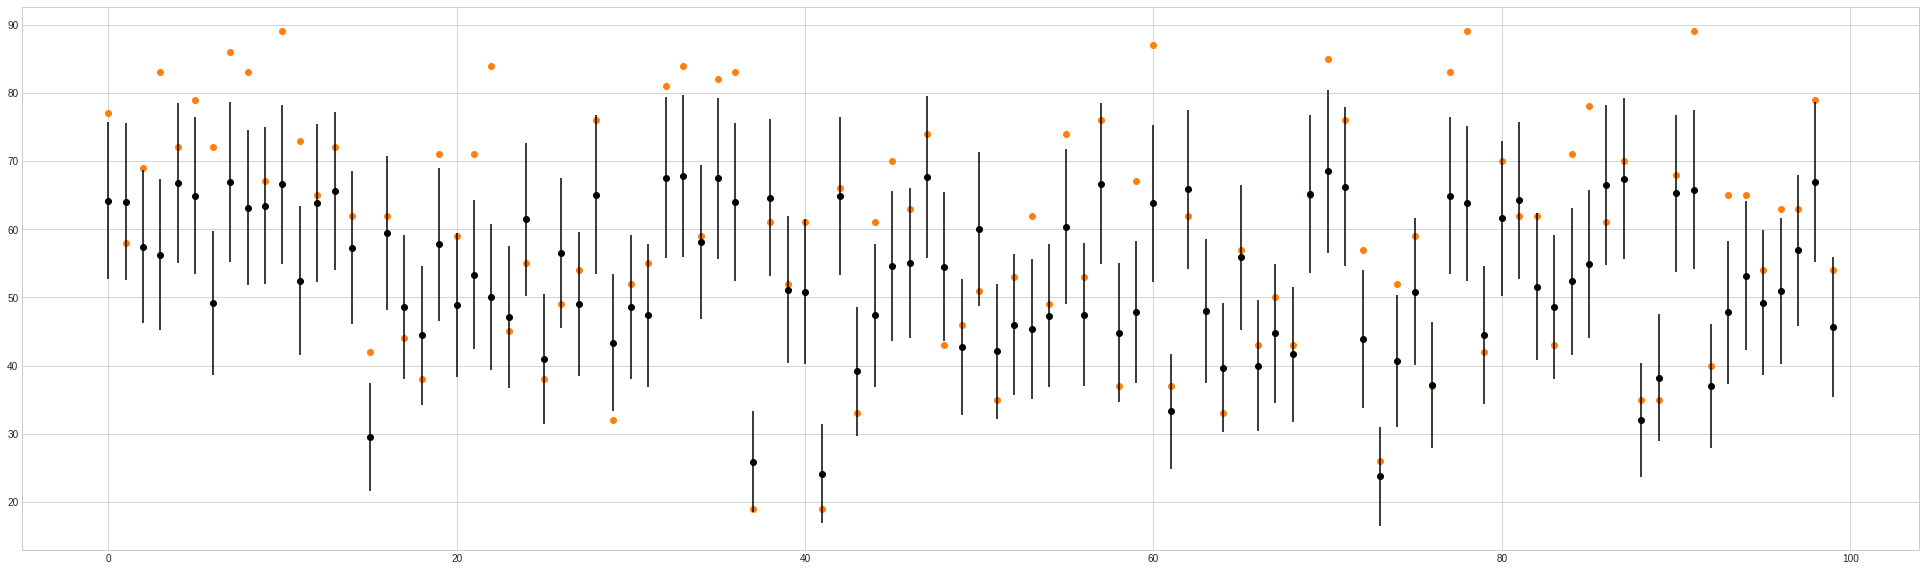

In [193]:
plt.figure(figsize=(34,10))
for i in range(100):
  plt.errorbar(x=i,y=prediction_mean[i][0],yerr=prediction_stdv[i][0],fmt='.k', marker='o')
  plt.scatter(x=i, y=age[i], color="C1")
plt.show()